In [1]:
import numpy as np
from qiskit import *

In [2]:
from qiskit.circuit import Gate

my_gate = Gate(name='my_gate', num_qubits=2, params=[])

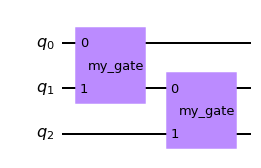

In [3]:
qr = QuantumRegister(3, 'q')
circ = QuantumCircuit(qr)
circ.append(my_gate, [qr[0], qr[1]])
circ.append(my_gate, [qr[1], qr[2]])

circ.draw()

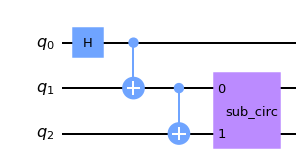

In [4]:
# Build a sub-circuit
sub_q = QuantumRegister(2)
sub_circ = QuantumCircuit(sub_q, name='sub_circ')
sub_circ.h(sub_q[0])
sub_circ.crz(1, sub_q[0], sub_q[1])
sub_circ.barrier()
sub_circ.id(sub_q[1])
sub_circ.u(1, 2, -2, sub_q[0])

# Convert to a gate and stick it into an arbitrary place in the bigger circuit
sub_inst = sub_circ.to_instruction()

qr = QuantumRegister(3, 'q')
circ = QuantumCircuit(qr)
circ.h(qr[0])
circ.cx(qr[0], qr[1])
circ.cx(qr[1], qr[2])
circ.append(sub_inst, [qr[1], qr[2]])

circ.draw()

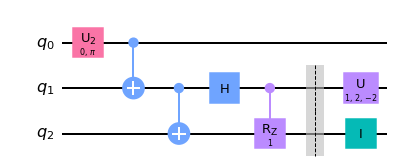

In [5]:
decomposed_circ = circ.decompose() # Does not modify original circuit
decomposed_circ.draw()

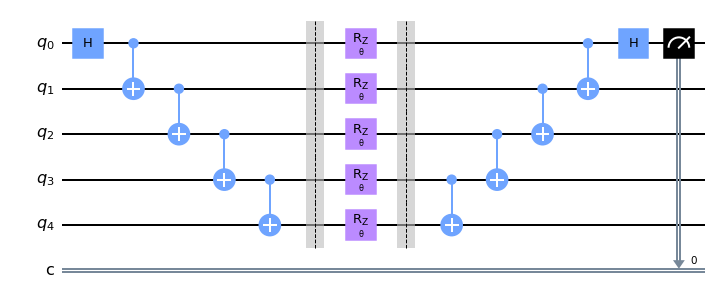

In [6]:
from qiskit.circuit import Parameter

theta = Parameter('θ')

n = 5

qc = QuantumCircuit(5, 1)

qc.h(0)
for i in range(n-1):
    qc.cx(i, i+1)

qc.barrier()
qc.rz(theta, range(5))
qc.barrier()

for i in reversed(range(n-1)):
    qc.cx(i, i+1)
qc.h(0)
qc.measure(0, 0)

qc.draw('mpl')

In [7]:
print(qc.parameters)

ParameterView([Parameter(θ)])


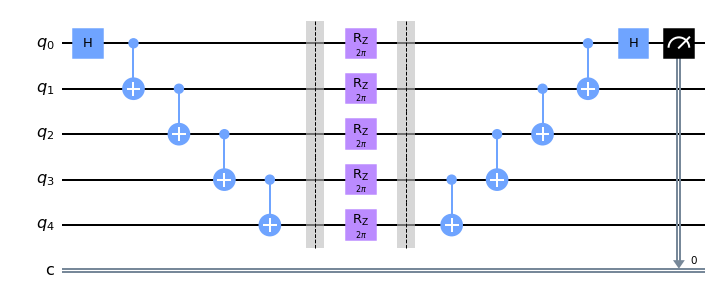

In [8]:
import numpy as np

theta_range = np.linspace(0, 2 * np.pi, 128)

circuits = [qc.bind_parameters({theta: theta_val})
            for theta_val in theta_range]

circuits[-1].draw()

In [9]:

backend = BasicAer.get_backend('qasm_simulator')
job = backend.run(transpile(circuits, backend))
counts = job.result().get_counts()

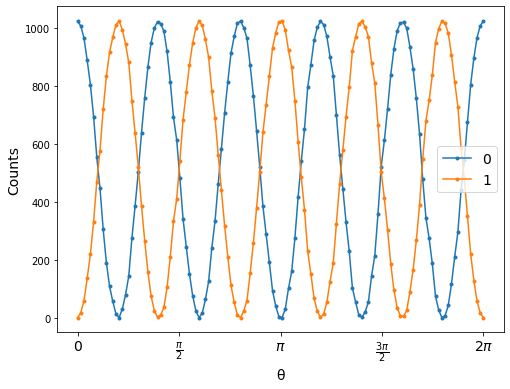

In [10]:

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(theta_range, list(map(lambda c: c.get('0', 0), counts)), '.-', label='0')
ax.plot(theta_range, list(map(lambda c: c.get('1', 0), counts)), '.-', label='1') 

ax.set_xticks([i * np.pi / 2 for i in range(5)])
ax.set_xticklabels(['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'], fontsize=14)
ax.set_xlabel('θ', fontsize=14)
ax.set_ylabel('Counts', fontsize=14)
ax.legend(fontsize=14)

In [15]:
import time
from itertools import combinations
from qiskit.compiler import assemble
from qiskit.test.mock import FakeVigo

start = time.time()
qcs = []

theta_range = np.linspace(0, 2*np.pi, 32)

for n in theta_range:
    qc = QuantumCircuit(5)

    for k in range(8):
        for i,j in combinations(range(5), 2):
            qc.cx(i,j)
        qc.rz(n, range(5))
        for i,j in combinations(range(5), 2):
            qc.cx(i,j)

    qcs.append(qc)
    
compiled_circuits = transpile(qcs, backend=FakeVigo())
qobj = assemble(compiled_circuits, backend=FakeVigo())

end = time.time()
print('Time compiling over set of bound circuits: ', end-start)

Time compiling over set of bound circuits:  5.943259954452515


In [16]:
start = time.time()
qc = QuantumCircuit(5)
theta = Parameter('theta')

for k in range(8):
    for i,j in combinations(range(5), 2):
        qc.cx(i,j)
    qc.rz(theta, range(5))
    for i,j in combinations(range(5), 2):
        qc.cx(i,j)

transpiled_qc = transpile(qc, backend=FakeVigo())
qobj = assemble([transpiled_qc.bind_parameters({theta: n})
                 for n in theta_range], backend=FakeVigo())
end = time.time()
print('Time compiling over parameterized circuit, then binding: ', end-start)

Time compiling over parameterized circuit, then binding:  2.1444013118743896


In [19]:
phi = Parameter('phi')

sub_circ1 = QuantumCircuit(2, name='sc_1')
sub_circ1.rz(phi, 0)
sub_circ1.rx(phi, 1)

sub_circ2 = QuantumCircuit(2, name='sc_2')
sub_circ2.rx(phi, 0)
sub_circ2.rz(phi, 1)

qc = QuantumCircuit(4)
qr = qc.qregs[0]

qc.append(sub_circ1.to_instruction(), [qr[0], qr[1]])
qc.append(sub_circ2.to_instruction(), [qr[0], qr[1]])

qc.append(sub_circ2.to_instruction(), [qr[2], qr[3]])

print(qc.draw())

# The following raises an error: "QiskitError: 'Name conflict on adding parameter: phi'"
# phi2 = Parameter('phi')
# qc.u3(0.1, phi2, 0.3, 0)

Figure(206.997x264.88)


In [20]:


p = Parameter('p')
qc = QuantumCircuit(3, name='oracle')
qc.rz(p, 0)
qc.cx(0, 1)
qc.rz(p, 1)
qc.cx(1, 2)
qc.rz(p, 2)

theta = Parameter('theta')
phi = Parameter('phi')
gamma = Parameter('gamma')

qr = QuantumRegister(9)
larger_qc = QuantumCircuit(qr)
larger_qc.append(qc.to_instruction({p: theta}), qr[0:3])
larger_qc.append(qc.to_instruction({p: phi}), qr[3:6])
larger_qc.append(qc.to_instruction({p: gamma}), qr[6:9])
print(larger_qc.draw())

print(larger_qc.decompose().draw())


Figure(233.54x565.88)
Figure(414.14x565.88)
